In [12]:
# Imports and Setups
import os
import cv2
import shutil
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
import tensorflow as tf

# Print major libraries versions
print("OpenCV version     :", cv2.__version__)
print("TensorFlow version :", tf.__version__)

OpenCV version     : 4.8.0
TensorFlow version : 2.13.0


In [13]:
# Set up paths and labels
RAW_DIR = '../../data/raw/fer2013'
PROCESSED_DIR = '../../data/processed/FC211012_Azeem'

TARGET_CLASSES = ['happy', 'neutral', 'sad', 'surprise', 'stressed']
MERGE_CLASSES = {'angry': 'stressed', 'disgust': 'stressed'}
IGNORE_CLASSES = ['fear']

# Counters
class_counts = {'train': defaultdict(int), 'test': defaultdict(int)}
merged_counts = {'train': defaultdict(int), 'test': defaultdict(int)}
raw_classes = set()

In [14]:
# Function to process one dataset split
def process_split(split):
    raw_path = os.path.join(RAW_DIR, split)
    save_path = os.path.join(PROCESSED_DIR, split)

    # Clean old folder
    if os.path.exists(save_path):
        shutil.rmtree(save_path)
    for cls in TARGET_CLASSES:
        os.makedirs(os.path.join(save_path, cls), exist_ok=True)

    # Go through all emotion folders
    for emotion in os.listdir(raw_path):
        emotion_path = os.path.join(raw_path, emotion)
        if not os.path.isdir(emotion_path):
            continue

        raw_classes.add(emotion)

        for img_file in tqdm(os.listdir(emotion_path), desc=f"{split.upper()} - {emotion}"):
            # Decide label
            if emotion in MERGE_CLASSES:
                label = MERGE_CLASSES[emotion]
                merged_counts[split][emotion] += 1
            elif emotion in TARGET_CLASSES:
                label = emotion
            elif emotion in IGNORE_CLASSES:
                continue
            else:
                continue

            # Read and validate image
            img_path = os.path.join(emotion_path, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            # Use NumPy to validate shape
            if img is None or not isinstance(img, np.ndarray) or img.shape != (48, 48):
                continue

            # Save to processed directory
            save_file = f"{emotion}_{img_file}"
            save_to = os.path.join(save_path, label, save_file)
            cv2.imwrite(save_to, img)

            class_counts[split][label] += 1

In [15]:
# Run for both train and test
process_split('train')
process_split('test')
print("Data processed successfully!.")

TEST - surprise: 100%|██████████| 831/831 [00:08<00:00, 100.43it/s]

Data processed successfully!.


In [16]:
# Show summary
print(" All Raw Classes Found:", sorted(raw_classes))
print("\n Target Classes:", TARGET_CLASSES)

for split in ['train', 'test']:
    print(f"\n {split.upper()} SET:")
    for cls in TARGET_CLASSES:
        count = class_counts[split][cls]
        print(f"   - {cls:10}: {count} images", end='')

        if cls == 'stressed':
            angry = merged_counts[split]['angry']
            disgust = merged_counts[split]['disgust']
            print(f" (from angry={angry}, disgust={disgust})")
        else:
            print()

 All Raw Classes Found: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

 Target Classes: ['happy', 'neutral', 'sad', 'surprise', 'stressed']

 TRAIN SET:
   - happy     : 7215 images
   - neutral   : 4965 images
   - sad       : 4830 images
   - surprise  : 3171 images
   - stressed  : 4431 images (from angry=3995, disgust=436)

 TEST SET:
   - happy     : 1774 images
   - neutral   : 1233 images
   - sad       : 1247 images
   - surprise  : 831 images
   - stressed  : 1069 images (from angry=958, disgust=111)


Saved plot: ../../data/processed/FC211012_Azeem\train_distribution.png


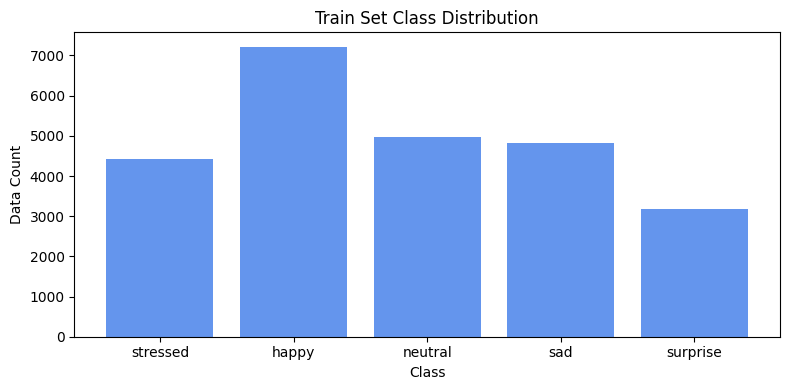

Saved plot: ../../data/processed/FC211012_Azeem\test_distribution.png


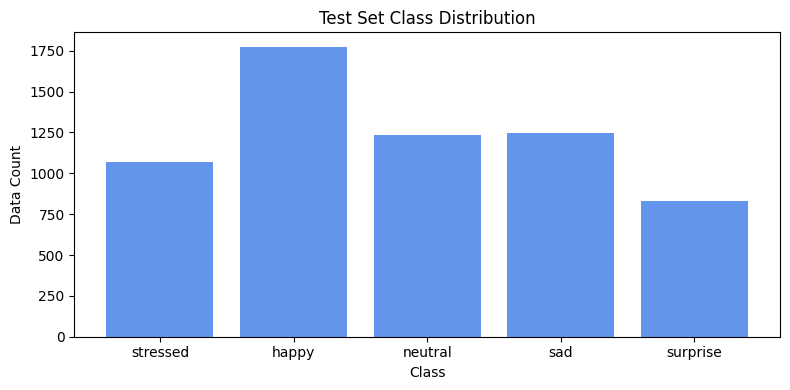

In [17]:
# Plot charts for both sets
for split in ['train', 'test']:
    labels = list(class_counts[split].keys())
    values = [class_counts[split][label] for label in labels]

    plt.figure(figsize=(8, 4))
    plt.bar(labels, values, color='cornflowerblue')
    plt.title(f"{split.capitalize()} Set Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Data Count")
    plt.tight_layout()

    # Save plot
    save_path = os.path.join(PROCESSED_DIR, f"{split}_distribution.png")
    plt.savefig(save_path)
    print(f"Saved plot: {save_path}")
    plt.show()